In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
import cx_Oracle
from config import oracle_wfm_key
from config import oracle_ods_key
from sqlalchemy.types import String
from tqdm import tqdm
import datetime
from datetime import datetime
import datetime as dt
import time
import databases as db
import os

In [2]:
# Get the current date
current_date = datetime.today()
# Set service level goal
service_level_goal = 0.65
# load the dataset
ods = db.oracle('cco_wfm',oracle_wfm_key)
query = f'''SELECT * FROM "CCO_WFM"."Staffing_Analysis_Regressors"'''
df = pd.read_sql(query, ods)

In [3]:
df['workgroup_set'].unique()

array(['Repair_ABS', 'Other', 'FST_Dispatch',
       'Financial_Services_Business', 'Financial_Services_Residential',
       'Wireline_Consumer_Sales', 'Repair_Cable_Business',
       'Repair_Cable_Residential', 'Cable_Seniors_CCO_Support',
       'Repair_RPC', 'Cable_Consumer_Sales',
       'Wireline_Seniors_CCO_Support', 'COAST', 'Repair_Continuum',
       'TDS_Corporate', 'Continuum_Sales', 'Repair_Wireline_Business',
       'Repair_Seniors', 'APC', 'Commercial_Billing',
       'Wireline_Consumer_Specialist', 'Repair_Wireline_Residential',
       'Cable_Consumer_Specialist', 'Repair_Support-Chat'], dtype=object)

In [4]:
sales_df = df.loc[((df['workgroup_set'] == 'Cable_Consumer_Sales') | (df['workgroup_set'] == 'Wireline_Consumer_Sales')) & (df['call_date'] < pd.Timestamp(current_date.year, current_date.month, 1)) ]

In [5]:
# Group the sum of offered_calls by call_date
offered_calls = sales_df.groupby('call_date')['offered_calls'].sum().reset_index()

In [6]:
# Group the sum of inbound_handle by call_date
avg_handle_time = sales_df.groupby('call_date')['inbound_handle'].sum().reset_index()

# Calculate average handle time by dividing grouped offered_calls by the sum of inbound_handle
avg_handle_time['avg_handle_time'] = avg_handle_time['inbound_handle'] / sales_df.groupby('call_date')['offered_calls'].sum().values

# Drop extra columns
avg_handle_time.drop(columns=['inbound_handle'], inplace=True)

In [7]:
# Group offered_calls and in_sl by call_date
service_level_percent = sales_df.groupby('call_date').agg({'offered_calls': 'sum', 'in_sl': 'sum'}).reset_index()

# Calculate service_level_percent by dividing in_sl by offered_calls
service_level_percent['service_level_percent'] = service_level_percent['in_sl'] / service_level_percent['offered_calls']

# Drop extra columns
service_level_percent.drop(columns=['offered_calls', 'in_sl'], inplace=True)

In [8]:
# Group offered_calls and in_sl by call_date
service_level_percent_to_goal = sales_df.groupby('call_date').agg({'offered_calls': 'sum', 'in_sl': 'sum'}).reset_index()

# Calculate service_level_percent by dividing in_sl by offered_calls
service_level_percent_to_goal['service_level_percent'] = service_level_percent_to_goal['in_sl'] / service_level_percent_to_goal['offered_calls']

# Calculate service_level_percent by dividing in_sl by offered_calls
service_level_percent_to_goal['service_level_percent_to_goal'] = service_level_percent_to_goal['service_level_percent'] / service_level_goal

# Drop extra columns
service_level_percent_to_goal.drop(columns=['offered_calls', 'in_sl','service_level_percent'], inplace=True)

In [9]:
# Group the sum of offered_calls and abandoned_calls by call_date
abandon_percent = sales_df.groupby('call_date').agg({'offered_calls': 'sum', 'abandoned_calls': 'sum'}).reset_index()

# Calculate abandon_percent by dividing abandoned_calls by offered_calls
abandon_percent['abandon_percent'] = abandon_percent['abandoned_calls'] / abandon_percent['offered_calls']

# Drop extra columns
abandon_percent.drop(columns=['offered_calls', 'abandoned_calls'], inplace=True)

In [10]:
# Group the sum of offered_calls and queuetime by call_date
avg_speed_of_answer = sales_df.groupby('call_date').agg({'offered_calls': 'sum', 'queuetime': 'sum'}).reset_index()

# Calculate avg_speed_of_answer by dividing queuetime by offered_calls
avg_speed_of_answer['avg_speed_of_answer'] = avg_speed_of_answer['queuetime'] / avg_speed_of_answer['offered_calls']

# Drop extra columns
avg_speed_of_answer.drop(columns=['offered_calls', 'queuetime'], inplace=True)

In [11]:
# Group the maximum of occupancy by call_date
occupancy = sales_df.groupby('call_date')['occupancy'].max().reset_index()

In [12]:
# Group the maximum of attrition by workgroup_set and call_date
grouped_df = sales_df.groupby(['workgroup_set', 'call_date'])['attrition'].max().reset_index()

# Sum the totals by call_date
attrition = grouped_df.groupby('call_date')['attrition'].sum().reset_index()

In [13]:
seniors = df.loc[((df['workgroup_set'] == 'Cable_Seniors_CCO_Support') | (df['workgroup_set'] == 'Wireline_Seniors_CCO_Support')) & (df['call_date'] < pd.Timestamp(current_date.year, current_date.month, 1)) ]
# Group the sum of offered_calls by call_date
senior_calls = seniors.groupby('call_date')['offered_calls'].sum().reset_index()
senior_calls.columns = ['call_date','senior_calls']

In [14]:
call_date = offered_calls['call_date']
offered_calls = offered_calls['offered_calls']
avg_handle_time = avg_handle_time['avg_handle_time']
service_level_percent = service_level_percent['service_level_percent']
abandon_percent = abandon_percent['abandon_percent']
avg_speed_of_answer = avg_speed_of_answer['avg_speed_of_answer']
occupancy = occupancy['occupancy']
attrition = attrition['attrition']
senior_calls = senior_calls['senior_calls']
service_level_percent_to_goal = service_level_percent_to_goal['service_level_percent_to_goal']

In [15]:
# Concatenate the independent variables to create the feature matrix
df = pd.concat([call_date,offered_calls, avg_handle_time, service_level_percent, abandon_percent,
                            avg_speed_of_answer, occupancy, attrition, senior_calls,service_level_percent_to_goal], axis=1)

# Print the resulting feature matrix
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   call_date                      24 non-null     datetime64[ns]
 1   offered_calls                  24 non-null     int64         
 2   avg_handle_time                24 non-null     float64       
 3   service_level_percent          24 non-null     float64       
 4   abandon_percent                24 non-null     float64       
 5   avg_speed_of_answer            24 non-null     float64       
 6   occupancy                      24 non-null     float64       
 7   attrition                      24 non-null     float64       
 8   senior_calls                   24 non-null     int64         
 9   service_level_percent_to_goal  24 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 2.0 KB
None


In [16]:
# Get unique months from 'call_date' column
unique_months = pd.to_datetime(df['call_date']).dt.to_period('M').unique()

# Calculate business days per month (including Saturdays)
business_days_per_month = []
for month in unique_months:
    start_date = month.to_timestamp()
    end_date = (month.to_timestamp() + pd.offsets.MonthEnd()).normalize()
    business_days = pd.bdate_range(start=start_date, end=end_date, freq='B').shape[0]
    business_days_per_month.append(business_days)

# Create a DataFrame with the results
business_days_df = pd.DataFrame({'call_date': unique_months, 'business_days': business_days_per_month})

In [17]:
# Read the DataFrame with monthly values
staffing = df
staffing['call_date'] = pd.to_datetime(staffing['call_date']).dt.to_period('M')
staffing = staffing.merge(business_days_df, on='call_date', how='left')


# Convert 'offered_calls' column to float
staffing['offered_calls'] = staffing['offered_calls'].astype(float)

# Calculate the Total Monthly Call Minutes
staffing['total_call_minutes'] = staffing['offered_calls'] * staffing['avg_handle_time']

# Calcualte the Staffing Requirements
shrinkage = 0.30
occupancy = staffing['occupancy'].mean()
working_hours_per_day = 7.1667
staffing['staffing_requirements'] = ((((staffing['total_call_minutes']) / 3600) / occupancy) * (1 + shrinkage)) / (staffing['business_days'] * working_hours_per_day)

In [18]:
staffing_requirements = staffing[['call_date','staffing_requirements']]
df = df.merge(staffing_requirements, on='call_date', how='inner')
# Convert 'call_date' to datetime format
df['call_date'] = df['call_date'].dt.to_timestamp()

# Extract the month and year from the 'call_date' column
df['month'] = df['call_date'].dt.month
df['year'] = df['call_date'].dt.year
# Drop the original 'call_date' column
df = df.drop(columns=['call_date'])

In [19]:
df

,offered_calls,avg_handle_time,service_level_percent,abandon_percent,avg_speed_of_answer,occupancy,attrition,senior_calls,service_level_percent_to_goal,staffing_requirements,month,year
0,311476,496.689649,0.667069,0.087047,172.364047,0.550151,8.0,20691,1.026260,578.871845,7,2021
1,388076,492.999670,0.700347,0.062194,124.680454,0.553214,7.0,21792,1.077457,715.873264,8,2021
2,372976,494.500643,0.639194,0.082150,162.542437,0.538106,11.0,22714,0.983375,690.113427,9,2021
3,366012,487.477711,0.541403,0.115472,232.472017,0.554362,4.0,22354,0.832928,699.400926,10,2021
4,344380,514.119775,0.726477,0.044544,94.508856,0.514637,8.0,21425,1.117656,662.483337,11,2021
5,316964,504.020217,0.848008,0.026274,57.021643,0.498815,4.0,18961,1.304628,571.775404,12,2021
6,329752,523.401502,0.697360,0.060773,130.630437,0.785003,15.0,18781,1.072862,676.547849,1,2022
7,295288,485.624814,0.770529,0.056921,117.538661,0.519964,10.0,17114,1.185429,590.217500,2,2022
8,358872,509.928833,0.665307,0.072059,150.252915,0.568055,12.0,19733,1.023549,654.962926,3,2022
9,355368,482.289525,0.592591,0.129196,276.556910,0.598281,6.0,18438,0.911679,671.834439,4,2022


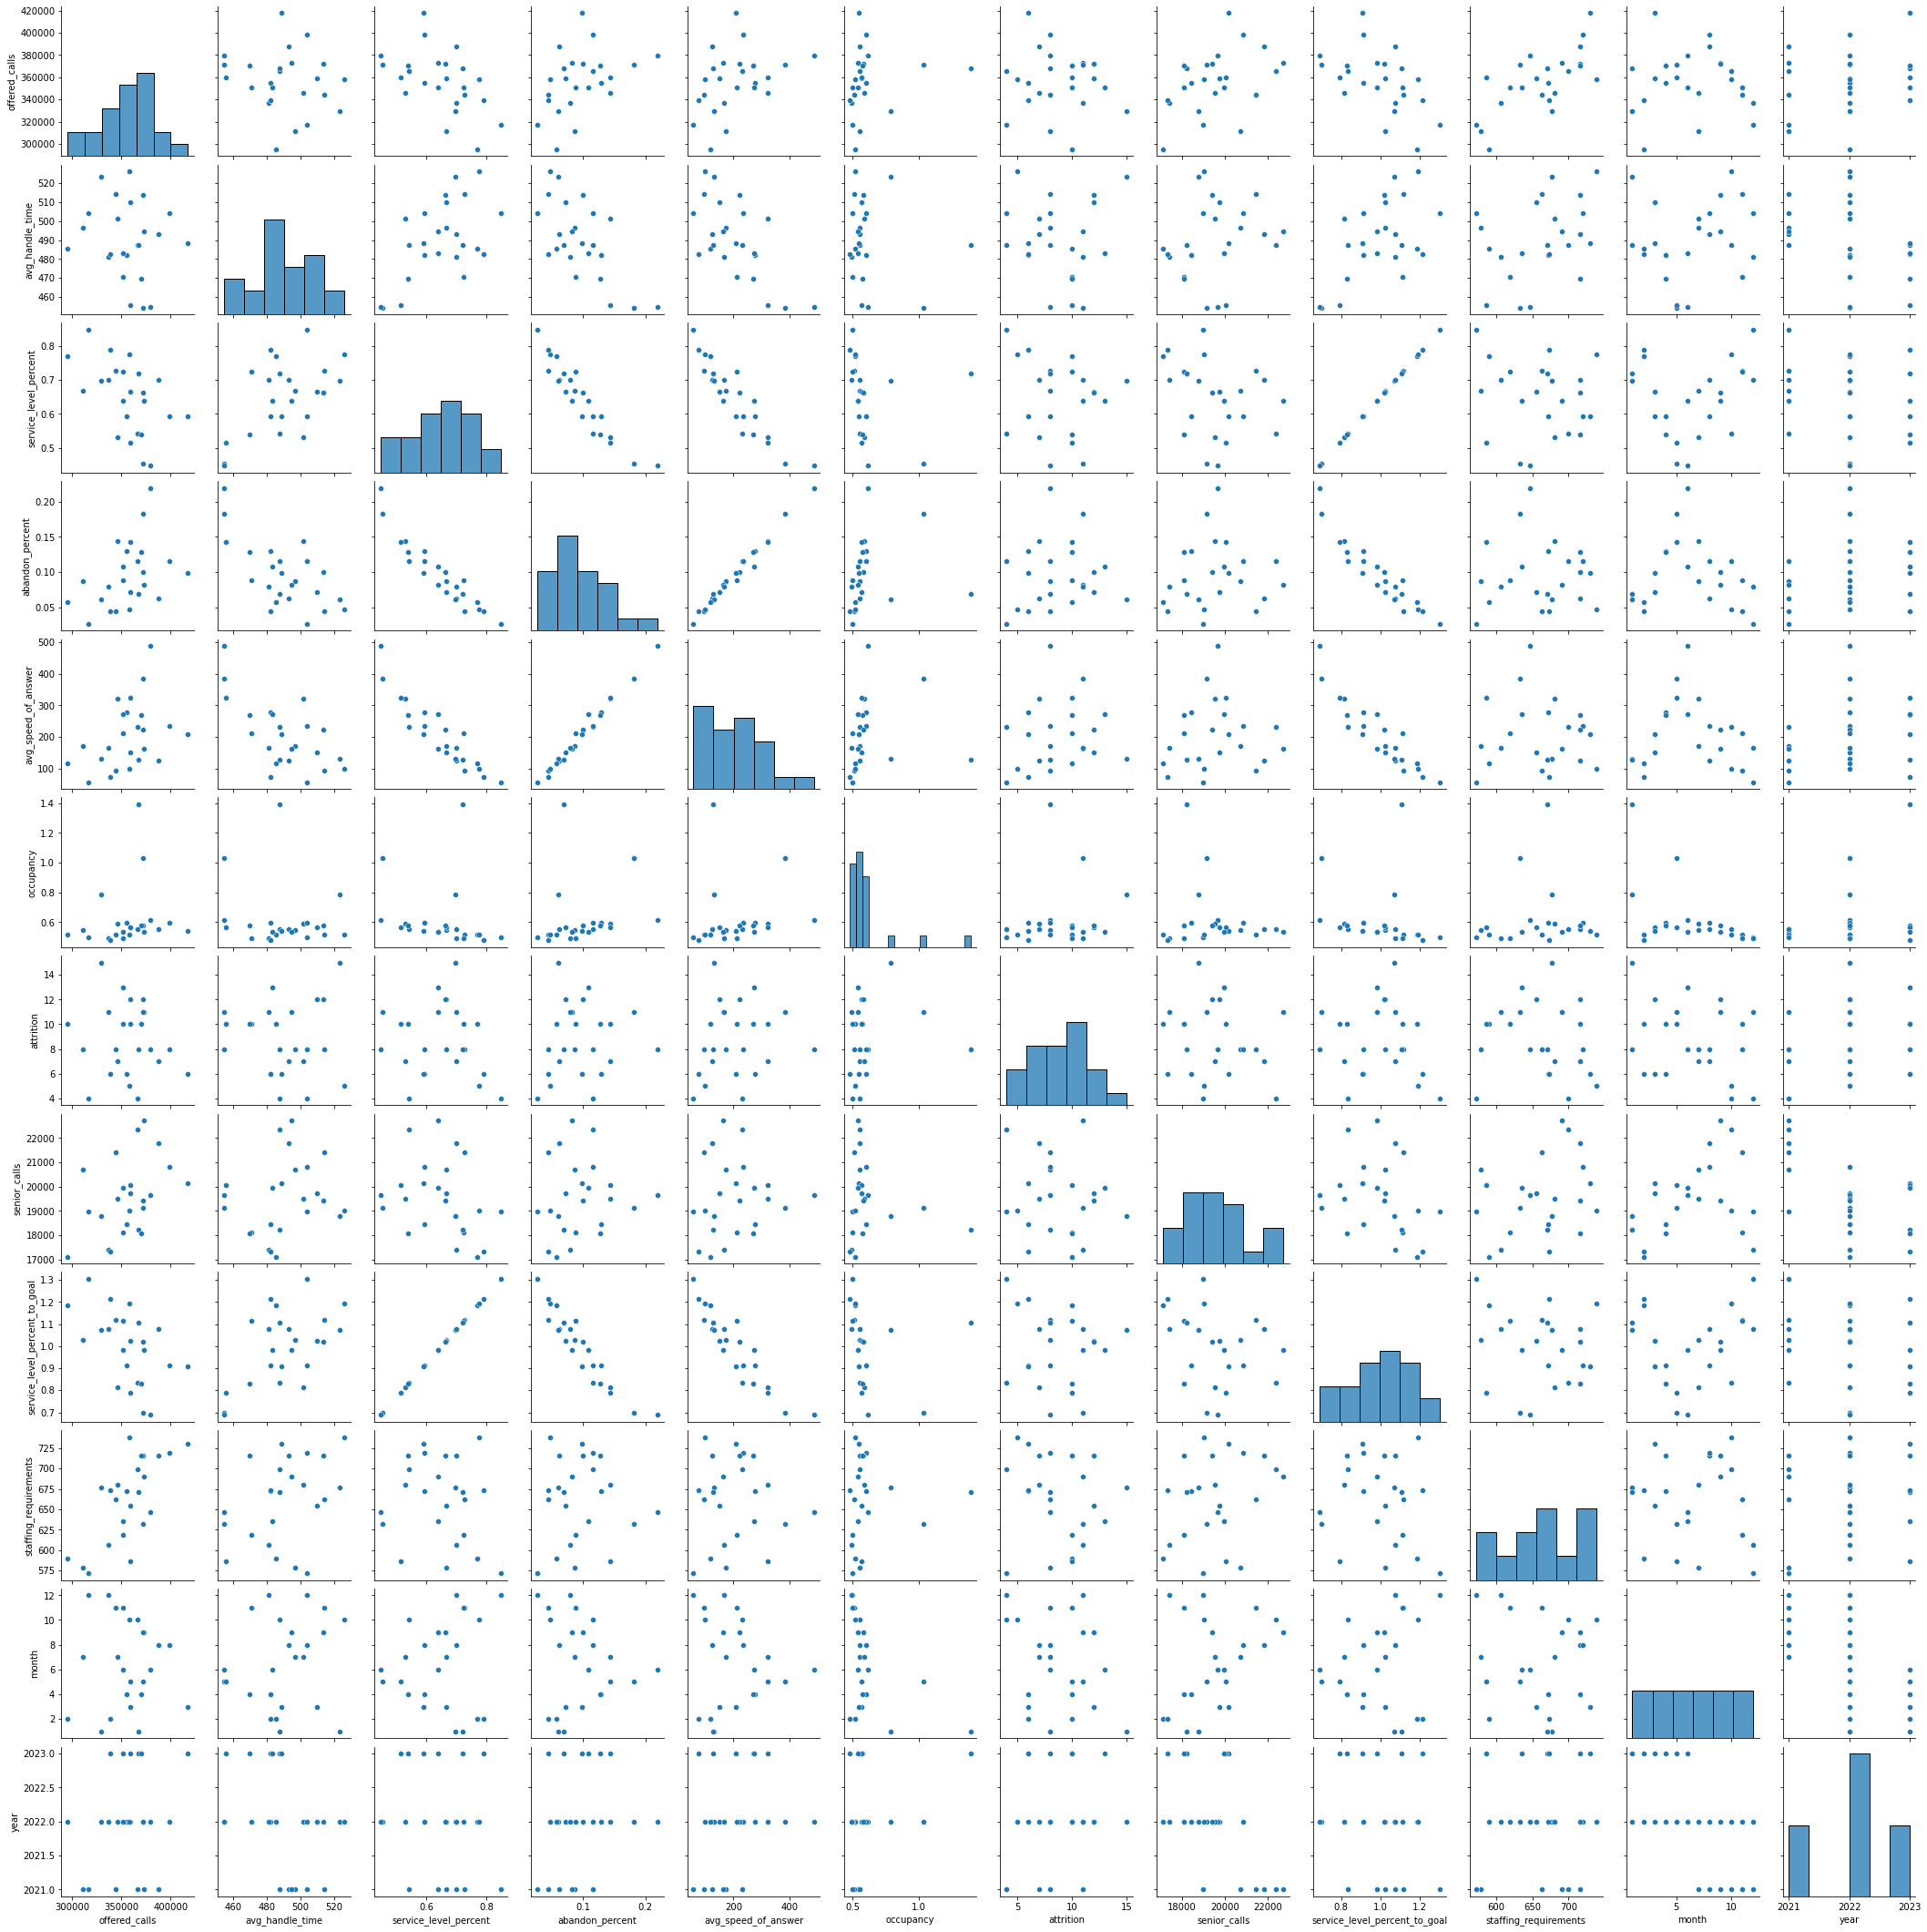

In [20]:
# Plot pairplot
sns.pairplot(df)
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'gradient_boost_pairplot.png')
plt.savefig(chart_path)

# Display the plot
plt.show()

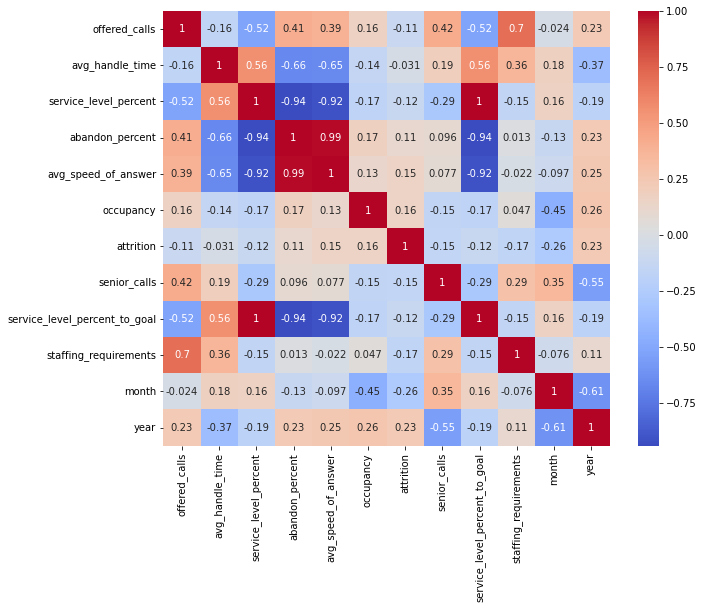

In [21]:
# Calculate correlations
correlations = df.corr()

# Display the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
# Save the plot to the 'visualizations' folder
chart_path = os.path.join('visualizations', 'gradient_boost_correlations.png')
plt.savefig(chart_path)

# Display the plot
plt.show()

In [22]:
# Define the feature set X and the target y
X = df.drop(columns='staffing_requirements')
y = df['staffing_requirements']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19, 11), (5, 11), (19,), (5,))

In [23]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}') 
print(f'Mean Squared Error (MSE): {mse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error (MAE): 38.33594264820454
Mean Squared Error (MSE): 1864.485016564306
R^2 Score: -0.778016277629954


In [24]:
# Get the coefficients of the linear regression model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(coefficients)

                          Feature  Coefficient
0                   offered_calls     0.001189
1                 avg_handle_time     1.885094
2           service_level_percent   -45.290988
3                 abandon_percent  2221.448352
4             avg_speed_of_answer    -0.991097
5                       occupancy   -93.456404
6                       attrition     0.018963
7                    senior_calls    -0.004340
8   service_level_percent_to_goal   -69.678442
9                           month    -3.263936
10                           year     0.169425


In [25]:
# Instantiate the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

In [26]:
# Calculate performance metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Mean Absolute Error (MAE): {mae_rf}') 
print(f'Mean Squared Error (MSE): {mse_rf}')
print(f'R^2 Score: {r2_rf}')

Mean Absolute Error (MAE): 32.81880253477125
Mean Squared Error (MSE): 1417.8472142315672
R^2 Score: -0.352092081030174


In [27]:
# Get the feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})

In [28]:
# Sort the features by their importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                          Feature  Importance
0                   offered_calls    0.379170
1                 avg_handle_time    0.188094
9                           month    0.092795
4             avg_speed_of_answer    0.089943
7                    senior_calls    0.052591
5                       occupancy    0.051397
6                       attrition    0.049085
2           service_level_percent    0.041301
8   service_level_percent_to_goal    0.034440
3                 abandon_percent    0.011596
10                           year    0.009590


In [29]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_gb = gb_model.predict(X_test)

# Calculate performance metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Mean Absolute Error (MAE): {mae_gb}') 
print(f'Mean Squared Error (MSE): {mse_gb}')
print(f'R^2 Score: {r2_gb}')

Mean Absolute Error (MAE): 30.812205962433268
Mean Squared Error (MSE): 1112.483665397844
R^2 Score: -0.06089029844803795


In [30]:
# Get the feature importances from the Gradient Boosting model
feature_importances_gb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
})

# Sort the features by their importance
feature_importances_gb = feature_importances_gb.sort_values(by='Importance', ascending=False)

print(feature_importances_gb)


                          Feature  Importance
0                   offered_calls    0.478357
1                 avg_handle_time    0.228605
9                           month    0.137236
2           service_level_percent    0.054842
8   service_level_percent_to_goal    0.037743
5                       occupancy    0.019051
7                    senior_calls    0.012416
6                       attrition    0.009937
10                           year    0.009273
4             avg_speed_of_answer    0.008958
3                 abandon_percent    0.003583
